In [30]:
# Duffing Oscillator - LSTM Multi-Step Prediction (Non-Recursive)
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from glob import glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split

In [31]:
# Dataset class for multi-step prediction
class DuffingMultiStepDataset(Dataset):
    def __init__(self, data_dir, window_size=10, pred_horizon=10):
        self.window_size = window_size
        self.pred_horizon = pred_horizon
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()
        self.X, self.y = self.create_dataset_from_csv(data_dir)

    def create_dataset_from_csv(self, data_dir):
        all_csv_files = sorted(glob(os.path.join(data_dir, "*.csv")))
        #chaotic_files = [f for f in all_csv_files if "F1.0" in f and ("w1.2" in f or "w1.4" in f)]
        np.random.seed(42)
        #selected_files = np.random.choice(chaotic_files, size=min(100, len(chaotic_files)), replace=False)
        selected_files = np.random.choice(all_csv_files, size=min(100, len(all_csv_files)), replace=False)

        X_all, y_all = [], []

        for file in selected_files:
            df = pd.read_csv(file)
            df = df[df['t'] < 30.0].reset_index(drop=True)
            df = df.iloc[::5].reset_index(drop=True)

            series = df[["x", "v"]].values
            for i in range(len(series) - self.window_size - self.pred_horizon):
                input_seq = series[i:i + self.window_size]
                target_seq = series[i + self.window_size:i + self.window_size + self.pred_horizon]
                X_all.append(input_seq)
                y_all.append(target_seq)

        X_all = np.array(X_all)
        y_all = np.array(y_all)

        X_scaled = self.scaler_X.fit_transform(X_all.reshape(-1, 2)).reshape(X_all.shape)
        y_scaled = self.scaler_y.fit_transform(y_all.reshape(-1, 2)).reshape(y_all.shape)

        return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y_scaled, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [32]:
# LSTM model for multi-step prediction
class DuffingMultiLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, pred_horizon=10, num_layers=1):
        super(DuffingMultiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim * pred_horizon)
        self.pred_horizon = pred_horizon
        self.output_dim = output_dim

    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        pred = self.fc(last_out)
        return pred.view(-1, self.pred_horizon, self.output_dim)


In [33]:
# Training function
def train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=50, device="cpu"):
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        train_losses.append(total_train_loss / len(train_loader))

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_pred = model(x_val)
                val_loss = loss_fn(val_pred, y_val)
                total_val_loss += val_loss.item()
        val_losses.append(total_val_loss / len(val_loader))

        print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.6f} | Val Loss: {val_losses[-1]:.6f}")

    return train_losses, val_losses

In [34]:
def plot_multistep_prediction(y_true, y_pred, scaler_y):
    y_true = scaler_y.inverse_transform(y_true.reshape(-1, 2)).reshape(y_true.shape)
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 2)).reshape(y_pred.shape)
    steps = np.arange(y_true.shape[0])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(steps, y_true[:, 0], label="True x")
    plt.plot(steps, y_pred[:, 0], label="Pred x", linestyle="--")
    plt.title("Multi-step Prediction - Position")
    plt.xlabel("Step")
    plt.ylabel("x")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(steps, y_true[:, 1], label="True v")
    plt.plot(steps, y_pred[:, 1], label="Pred v", linestyle="--")
    plt.title("Multi-step Prediction - Velocity")
    plt.xlabel("Step")
    plt.ylabel("v")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Epoch 01 | Train Loss: 0.772158 | Val Loss: 0.691305
Epoch 02 | Train Loss: 0.672898 | Val Loss: 0.657359
Epoch 03 | Train Loss: 0.634307 | Val Loss: 0.610687
Epoch 04 | Train Loss: 0.611440 | Val Loss: 0.619752
Epoch 05 | Train Loss: 0.593343 | Val Loss: 0.629069
Epoch 06 | Train Loss: 0.585644 | Val Loss: 0.559655
Epoch 07 | Train Loss: 0.552535 | Val Loss: 0.541041
Epoch 08 | Train Loss: 0.530429 | Val Loss: 0.528696
Epoch 09 | Train Loss: 0.501597 | Val Loss: 0.517144
Epoch 10 | Train Loss: 0.490739 | Val Loss: 0.479156
Epoch 11 | Train Loss: 0.471126 | Val Loss: 0.469462
Epoch 12 | Train Loss: 0.460510 | Val Loss: 0.454561
Epoch 13 | Train Loss: 0.449684 | Val Loss: 0.445066
Epoch 14 | Train Loss: 0.445501 | Val Loss: 0.454351
Epoch 15 | Train Loss: 0.433769 | Val Loss: 0.466519
Epoch 16 | Train Loss: 0.426079 | Val Loss: 0.440182
Epoch 17 | Train Loss: 0.422572 | Val Loss: 0.438088
Epoch 18 | Train Loss: 0.411802 | Val Loss: 0.413281
Epoch 19 | Train Loss: 0.409333 | Val Loss: 0.

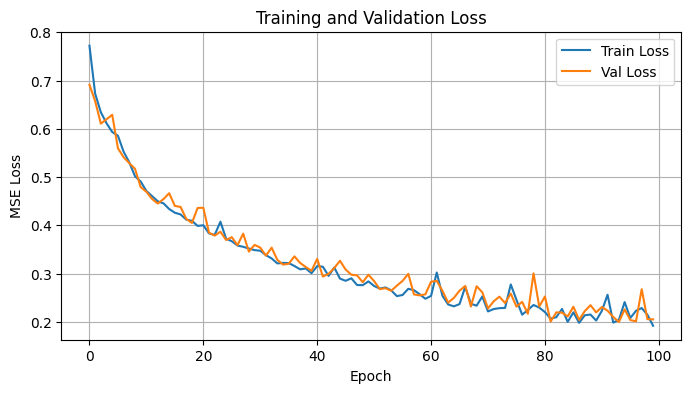

In [37]:
# === Pipeline ===
data_dir = "../data/raw/"
window_size = 80
pred_horizon = 240

dataset = DuffingMultiStepDataset(data_dir, window_size, pred_horizon)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = DuffingMultiLSTM(pred_horizon=pred_horizon)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
train_losses, val_losses = train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=100)
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


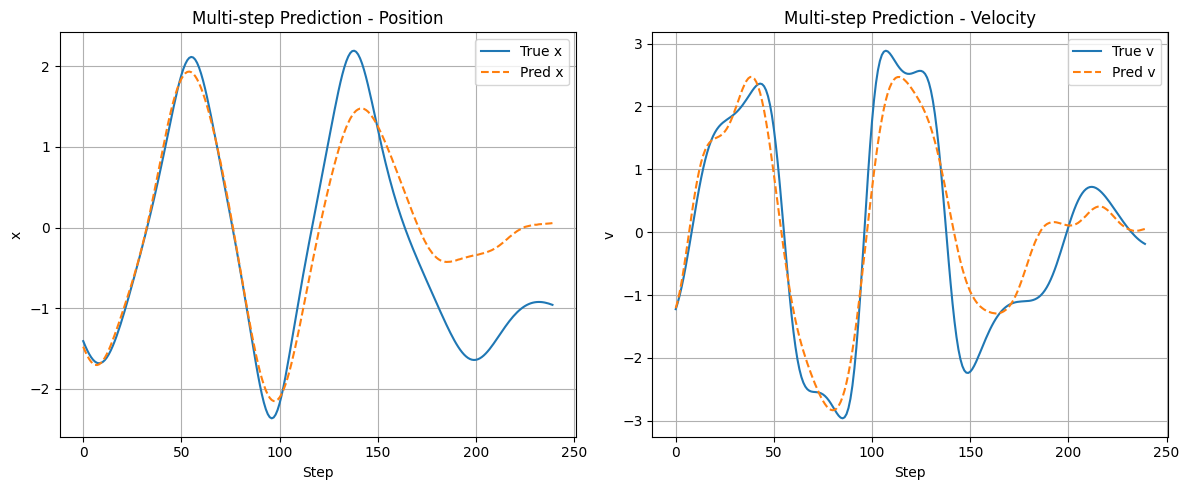

In [52]:
# Plot prediction from test set
model.eval()
with torch.no_grad():
    sample_x, sample_y = test_dataset[30]
    pred_y = model(sample_x.unsqueeze(0)).squeeze(0).cpu().numpy()
    true_y = sample_y.cpu().numpy()
    plot_multistep_prediction(true_y, pred_y, dataset.scaler_y)

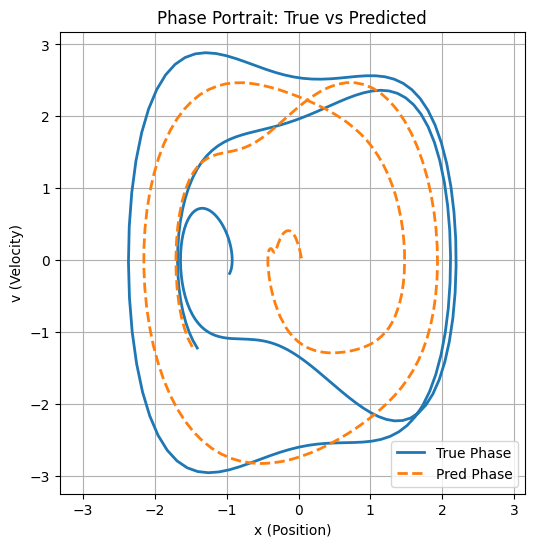

In [53]:
# Plot phase portrait of predicted vs true trajectory
import matplotlib.pyplot as plt

# Inverse transform predicted and true values
true_traj = dataset.scaler_y.inverse_transform(true_y)
pred_traj = dataset.scaler_y.inverse_transform(pred_y)

plt.figure(figsize=(6, 6))
plt.plot(true_traj[:, 0], true_traj[:, 1], label="True Phase", linewidth=2)
plt.plot(pred_traj[:, 0], pred_traj[:, 1], label="Pred Phase", linestyle="--", linewidth=2)
plt.xlabel("x (Position)")
plt.ylabel("v (Velocity)")
plt.title("Phase Portrait: True vs Predicted")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()


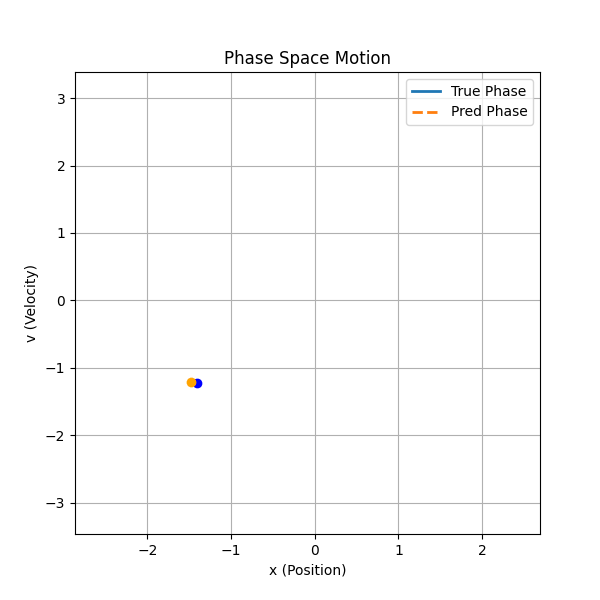

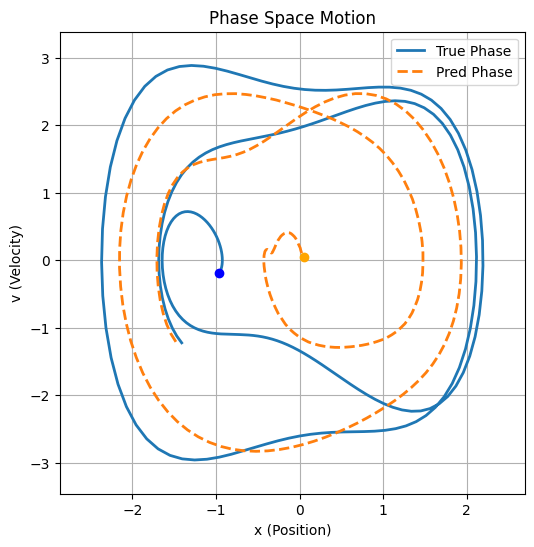

In [54]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(np.min(true_traj[:, 0]) - 0.5, np.max(true_traj[:, 0]) + 0.5)
ax.set_ylim(np.min(true_traj[:, 1]) - 0.5, np.max(true_traj[:, 1]) + 0.5)
ax.set_xlabel("x (Position)")
ax.set_ylabel("v (Velocity)")
ax.set_title("Phase Space Motion")
ax.grid(True)

# Phase trajectory lines
true_line, = ax.plot([], [], lw=2, label="True Phase")
pred_line, = ax.plot([], [], lw=2, linestyle='--', label="Pred Phase")

# Moving markers (dots) for the particles
true_dot, = ax.plot([], [], 'o', color='blue', markersize=6)
pred_dot, = ax.plot([], [], 'o', color='orange', markersize=6)

ax.legend()

def init():
    true_line.set_data([], [])
    pred_line.set_data([], [])
    true_dot.set_data([], [])
    pred_dot.set_data([], [])
    return true_line, pred_line, true_dot, pred_dot

def update(frame):
    true_line.set_data(true_traj[:frame, 0], true_traj[:frame, 1])
    pred_line.set_data(pred_traj[:frame, 0], pred_traj[:frame, 1])
    true_dot.set_data([true_traj[frame, 0]], [true_traj[frame, 1]])
    pred_dot.set_data([pred_traj[frame, 0]], [pred_traj[frame, 1]])
    return true_line, pred_line, true_dot, pred_dot


ani = animation.FuncAnimation(
    fig, update, frames=len(true_traj), init_func=init,
    blit=True, interval=30
)

# Save as a .gif
ani.save("duffing_phase_motion.gif", writer="pillow", fps=30)

# Display inline in Jupyter
from IPython.display import Image
Image(filename="duffing_phase_motion.gif")
